In [1]:
from apple_health_parser.utils.parser import Parser
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

In [2]:
parser = Parser(export_file=r"../export.zip", overwrite=True)

print(parser.flags)

Deleted previous export at data\apple_health_export...


['HKCategoryTypeIdentifierAppleStandHour', 'HKCategoryTypeIdentifierAudioExposureEvent', 'HKCategoryTypeIdentifierHeadphoneAudioExposureEvent', 'HKCategoryTypeIdentifierSleepAnalysis', 'HKDataTypeSleepDurationGoal', 'HKQuantityTypeIdentifierActiveEnergyBurned', 'HKQuantityTypeIdentifierAppleExerciseTime', 'HKQuantityTypeIdentifierAppleSleepingWristTemperature', 'HKQuantityTypeIdentifierAppleStandTime', 'HKQuantityTypeIdentifierAppleWalkingSteadiness', 'HKQuantityTypeIdentifierBasalEnergyBurned', 'HKQuantityTypeIdentifierBodyMass', 'HKQuantityTypeIdentifierDietaryCalcium', 'HKQuantityTypeIdentifierDietaryCarbohydrates', 'HKQuantityTypeIdentifierDietaryCholesterol', 'HKQuantityTypeIdentifierDietaryEnergyConsumed', 'HKQuantityTypeIdentifierDietaryFatSaturated', 'HKQuantityTypeIdentifierDietaryFatTotal', 'HKQuantityTypeIdentifierDietaryFiber', 'HKQuantityTypeIdentifierDietaryIron', 'HKQuantityTypeIdentifierDietaryMagnesium', 'HKQuantityTypeIdentifierDietaryPhosphorus', 'HKQuantityTypeIdent

## For the BMR predictor we want to use following features:

- Activity 
- Weight
- Food intake (calories)
- Type of activity?
- Heartrate
- Resting heartrate
- Sleep duration
- Height


## This corresponds to following flags:

* Activity:
    * HKQuantityTypeIdentifierStepCount
    * HKQuantityTypeIdentifierDistanceWalkingRunning
    * HKQuantityTypeIdentifierFlightsClimbed
    * HKQuantityTypeIdentifierAppleExerciseTime
    * HKCategoryTypeIdentifierAppleStandHour
    * HKQuantityTypeIdentifierAppleStandTime

* Body metrics:
    * Weight → HKQuantityTypeIdentifierBodyMass
    * Height → HKQuantityTypeIdentifierHeight

* Energy / Calories:
    * Food Intake (calories consumed) → HKQuantityTypeIdentifierDietaryEnergyConsumed
    * Active Calories (activity-based burn) → HKQuantityTypeIdentifierActiveEnergyBurned
    * Basal Calories (resting burn) → HKQuantityTypeIdentifierBasalEnergyBurned

* Heart Metrics:
    * Heart Rate → HKQuantityTypeIdentifierHeartRate
    * Resting Heart Rate → HKQuantityTypeIdentifierRestingHeartRate
    * HRV (variability) → HKQuantityTypeIdentifierHeartRateVariabilitySDNN
    * Walking Heart Rate Average → HKQuantityTypeIdentifierWalkingHeartRateAverage

* Sleep:
    * Sleep Duration → HKCategoryTypeIdentifierSleepAnalysis

### Helper functions:

In [3]:
def bmr_oxford_henry(weight_kg: float, age: int, sex: str) -> float:
    """
    Returns BMR (kcal/day) using Oxford Henry adult equations.
    Henry CJ. Public Health Nutr. 2005.
    """
    if pd.isna(weight_kg) or weight_kg <= 0:
        return np.nan
    sex = sex.lower()
    if age < 18:
        return np.nan

    if sex == "male":
        if 18 <= age < 30:
            return 15.057 * weight_kg + 692.2
        elif 30 <= age <= 60:
            return 11.472 * weight_kg + 873.1
        else:
            return 11.711 * weight_kg + 587.7
    elif sex == "female":
        if 18 <= age < 30:
            return 14.818 * weight_kg + 486.6
        elif 30 <= age <= 60:
            return 8.126 * weight_kg + 845.6
        else:
            return 9.082 * weight_kg + 658.5
    else:
        return np.nan

In [4]:
def adjust_bmr(bmr_base: float,
               resting_hr: float | None = None,
               hrv_ms: float | None = None,
               sleep_hours: float | None = None,
               vo2max: float | None = None,
               sleep_min_threshold: float = 6.0) -> float:
    """Heuristic 'Apple-like' personalization of BMR."""
    if pd.isna(bmr_base):
        return np.nan
    bmr = bmr_base

    if resting_hr is not None and not pd.isna(resting_hr):
        bmr *= (1.0 + (50.0 - resting_hr) / 600.0)

    if hrv_ms is not None and not pd.isna(hrv_ms):
        if hrv_ms < 30:
            bmr *= 0.97
        elif hrv_ms > 60:
            bmr *= 1.02

    if sleep_hours is not None and not pd.isna(sleep_hours):
        if sleep_hours < sleep_min_threshold:
            bmr *= 0.95

    if vo2max is not None and not pd.isna(vo2max):
        if vo2max > 55:
            bmr *= 1.02
        elif vo2max < 30:
            bmr *= 0.97

    return bmr


In [5]:
def load_csv_safely(path: Path):
    if path.exists():
        try:
            return pd.read_csv(path)
        except Exception as e:
            print(f"[WARN] Could not read {path}: {e}")
            return None
    else:
        print(f"[WARN] Missing expected file: {path}")
        return None

def ensure_datetime(df: pd.DataFrame, cols):
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_datetime(df[c], errors="coerce")
    return df

def safe_float(x):
    try:
        return float(x)
    except:
        return np.nan


In [6]:
from pathlib import Path
import re

HK = dict(
    BODY_MASS="HKQuantityTypeIdentifierBodyMass",
    HEIGHT="HKQuantityTypeIdentifierHeight",
    HR="HKQuantityTypeIdentifierHeartRate",
    RHR="HKQuantityTypeIdentifierRestingHeartRate",
    HRV="HKQuantityTypeIdentifierHeartRateVariabilitySDNN",
    VO2="HKQuantityTypeIdentifierVO2Max",
    STEPS="HKQuantityTypeIdentifierStepCount",
    DIST_RW="HKQuantityTypeIdentifierDistanceWalkingRunning",
    FLIGHTS="HKQuantityTypeIdentifierFlightsClimbed",
    EX_MIN="HKQuantityTypeIdentifierAppleExerciseTime",
    STAND_MIN="HKQuantityTypeIdentifierAppleStandTime",
    AE="HKQuantityTypeIdentifierActiveEnergyBurned",
    BE="HKQuantityTypeIdentifierBasalEnergyBurned",
    DIET_EN="HKQuantityTypeIdentifierDietaryEnergyConsumed",
    SLEEP="HKCategoryTypeIdentifierSleepAnalysis",
    WALK_HR_AVG="HKQuantityTypeIdentifierWalkingHeartRateAverage",
)

SLEEP_VALUES_ASLEEP = {"Asleep", "InBed", "asleep", "asleepCore", "asleepREM", "asleepDeep"}

# --- helpers for multi-CSV mode ---
def _norm(s: str) -> str:
    return re.sub(r'\W+', '', str(s).lower())

def _find_col(cols, *candidates):
    lookup = {_norm(c): c for c in cols}
    for cand in candidates:
        key = _norm(cand)
        if key in lookup:
            return lookup[key]
    return None

_EXCLUDE = {"workouts.csv", "activity_summaries.csv", "clinical_records.csv", "metadata.csv", "sources.csv"}

def _load_per_metric_dir(data_dir: Path) -> pd.DataFrame | None:
    frames = []
    for p in data_dir.glob("*.csv"):
        if p.name.lower() in _EXCLUDE:
            continue
        try:
            df = pd.read_csv(p)
        except pd.errors.EmptyDataError:
            print(f"[WARN] Skipping empty CSV: {p.name}")
            continue
        except Exception as e:
            print(f"[WARN] Could not read {p.name}: {e}")
            continue

        if df.empty:
            continue

        # derive 'type' from filename
        hk_type = p.stem
        # ... rest of the normalization as before ...

        cols = list(df.columns)
        # best-effort normalize
        start_col = _find_col(cols, "startDate", "start_date", "start", "date", "timestamp")
        end_col   = _find_col(cols, "endDate", "end_date", "end", "end_time")
        creation  = _find_col(cols, "creationDate", "creation_date", "created")
        value_col = _find_col(cols, "value", "quantity", "amount", "reading")
        unit_col  = _find_col(cols, "unit", "units")
        source    = _find_col(cols, "sourceName", "source_name", "source")

        out = pd.DataFrame()
        if start_col: out["startDate"] = df[start_col]
        if end_col:   out["endDate"]   = df[end_col]
        if creation:  out["creationDate"] = df[creation]
        if value_col: out["value"]     = df[value_col]
        if unit_col:  out["unit"]      = df[unit_col]
        if source:    out["sourceName"]= df[source]

        if out.empty and value_col is None:
            continue

        out["type"] = p.stem  # derive from filename
        frames.append(out)

    if not frames:
        return None
    return pd.concat(frames, ignore_index=True, sort=False)

# --- adapted aggregator: accepts DataFrame OR a directory path ---
def aggregate_records_daily(records: pd.DataFrame | str | Path) -> pd.DataFrame:
    if records is None or (isinstance(records, pd.DataFrame) and records.empty):
        return pd.DataFrame()

    # If a folder path was passed → merge per-metric CSVs
    if isinstance(records, (str, Path)):
        merged = _load_per_metric_dir(Path(records))
        if merged is None or merged.empty:
            return pd.DataFrame()
        records = merged

    # Ensure canonical column names exist
    cols = list(records.columns)
    if "startDate" not in cols:
        c = _find_col(cols, "startDate", "start_date", "start", "date", "timestamp")
        if c: records = records.rename(columns={c: "startDate"})
    if "endDate" not in cols:
        c = _find_col(cols, "endDate", "end_date", "end", "end_time")
        if c: records = records.rename(columns={c: "endDate"})
    if "creationDate" not in cols:
        c = _find_col(cols, "creationDate", "creation_date", "created")
        if c: records = records.rename(columns={c: "creationDate"})
    if "value" not in cols:
        c = _find_col(cols, "value", "quantity", "amount", "reading")
        if c: records = records.rename(columns={c: "value"})
    if "type" not in cols:
        c = _find_col(cols, "type", "identifier")
        if c: records = records.rename(columns={c: "type"})

    ensure_datetime(records, ["startDate", "endDate", "creationDate"])
    records["date"] = records["startDate"].dt.date
    records["value_float"] = records["value"].apply(safe_float)

    # ---- Energy (kcal) sums ----
    energy = records[records["type"].isin([HK["AE"], HK["BE"], HK["DIET_EN"]])].copy()
    energy_pivot = (energy
                    .pivot_table(index="date", columns="type", values="value_float", aggfunc="sum")
                    .rename_axis(None, axis=1))

    # ---- Steps / Distance / Flights / Minutes sums ----
    qty_sum_types = [HK["STEPS"], HK["DIST_RW"], HK["FLIGHTS"], HK["EX_MIN"], HK["STAND_MIN"]]
    qty_sum = (records[records["type"].isin(qty_sum_types)]
               .pivot_table(index="date", columns="type", values="value_float", aggfunc="sum")
               .rename_axis(None, axis=1))

    # ---- Heart metrics (means) ----
    hr_mean_types = [HK["HR"], HK["RHR"], HK["HRV"], HK["VO2"], HK["WALK_HR_AVG"]]
    hr_mean = (records[records["type"].isin(hr_mean_types)]
               .pivot_table(index="date", columns="type", values="value_float", aggfunc="mean")
               .rename_axis(None, axis=1))

    # ---- Body Mass (last of day) ----
    bm = records[records["type"] == HK["BODY_MASS"]][["date", "startDate", "value_float"]].copy()
    if not bm.empty:
        bm = bm.sort_values(["date", "startDate"]).groupby("date").tail(1).set_index("date")
        bm = bm.rename(columns={"value_float": HK["BODY_MASS"]})[[HK["BODY_MASS"]]]

    # ---- Sleep duration (hours) ----
    sleep = records[records["type"] == HK["SLEEP"]].copy()
    if not sleep.empty and "endDate" in sleep.columns and "startDate" in sleep.columns:
        sleep["dur_hours"] = (sleep["endDate"] - sleep["startDate"]).dt.total_seconds() / 3600.0
        if "value" in sleep.columns:
            sleep_asleep = sleep[sleep["value"].isin(SLEEP_VALUES_ASLEEP)]
            if not sleep_asleep.empty:
                sleep_daily = sleep_asleep.groupby("date")["dur_hours"].sum().to_frame("sleep_hours")
            else:
                sleep_daily = sleep.groupby("date")["dur_hours"].sum().to_frame("sleep_hours")
        else:
            sleep_daily = sleep.groupby("date")["dur_hours"].sum().to_frame("sleep_hours")
    else:
        sleep_daily = pd.DataFrame(columns=["sleep_hours"])

    # Merge all
    dfs = [d for d in [energy_pivot, qty_sum, hr_mean, bm if 'bm' in locals() else None, sleep_daily] if d is not None and not d.empty]
    if not dfs:
        return pd.DataFrame()
    daily = dfs[0]
    for d in dfs[1:]:
        daily = daily.join(d, how="outer")

    # Friendly column names
    rename_map = {
        HK["AE"]: "active_kcal",
        HK["BE"]: "basal_kcal",
        HK["DIET_EN"]: "diet_kcal",
        HK["STEPS"]: "steps",
        HK["DIST_RW"]: "distance_m",
        HK["FLIGHTS"]: "flights",
        HK["EX_MIN"]: "exercise_min",
        HK["STAND_MIN"]: "stand_min",
        HK["HR"]: "hr_mean",
        HK["RHR"]: "resting_hr_mean",
        HK["HRV"]: "hrv_ms_mean",
        HK["VO2"]: "vo2max_ml_kg_min",
        HK["WALK_HR_AVG"]: "walking_hr_avg",
        HK["BODY_MASS"]: "weight_kg",
    }
    daily = daily.rename(columns=rename_map)

    # Distance unit heuristic (km → m)
    if "distance_m" in daily.columns:
        med = daily["distance_m"].median(skipna=True)
        if not pd.isna(med) and med < 200:
            daily["distance_m"] = daily["distance_m"] * 1000.0

    return daily.sort_index()

def derive_extra_features(daily: pd.DataFrame, height_cm: float) -> pd.DataFrame:
    df = daily.copy()
    if "weight_kg" in df.columns and height_cm and height_cm > 0:
        h_m = height_cm / 100.0
        df["bmi"] = df["weight_kg"] / (h_m * h_m)
    else:
        df["bmi"] = np.nan

    for col in ["resting_hr_mean", "hrv_ms_mean", "vo2max_ml_kg_min", "sleep_hours", "weight_kg"]:
        if col in df.columns:
            df[f"{col}_7d"] = df[col].rolling(window=7, min_periods=3).mean()

    return df


In [7]:

sex="male"         # "male" or "female"
age=25                # your age in years
height_cm=175.0       # your height in centimeters
tef_frac=0.10         # thermic effect of food fraction (default 10%)
sleep_min_threshold=6 # sleep penalty threshold (hours)
out_suffix=""          # optional filename suffix for CSVs



data_dir = Path("files")

daily = aggregate_records_daily("../files")
daily = derive_extra_features(daily, height_cm)

# Weight ffill & BMRs
daily["weight_ffill"] = daily.get("weight_kg", pd.Series(index=daily.index)).ffill()
daily["bmr_oxford"] = daily["weight_ffill"].apply(lambda w: bmr_oxford_henry(w, age, sex))

rhr = daily.get("resting_hr_mean_7d", daily.get("resting_hr_mean"))
hrv = daily.get("hrv_ms_mean_7d", daily.get("hrv_ms_mean"))
slp = daily.get("sleep_hours_7d", daily.get("sleep_hours"))
v02 = daily.get("vo2max_ml_kg_min_7d", daily.get("vo2max_ml_kg_min"))


[WARN] Skipping empty CSV: HKCategoryTypeIdentifierAppleStandHour.csv
[WARN] Skipping empty CSV: HKCategoryTypeIdentifierAudioExposureEvent.csv
[WARN] Skipping empty CSV: HKCategoryTypeIdentifierHeadphoneAudioExposureEvent.csv


C:\Users\comi\AppData\Local\Temp\ipykernel_37808\4293708041.py:45: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(p)
C:\Users\comi\AppData\Local\Temp\ipykernel_37808\4293708041.py:45: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(p)
C:\Users\comi\AppData\Local\Temp\ipykernel_37808\4293708041.py:45: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(p)


### we have some missing or wrong values in my calorie intake because i did not always track properly

### specifically, from the 24.5.25 - 26.5.25 i ate way more than my usual diet 
### we make following assumption:

- on each day that i tracked less than 1500 calories, we approximate the caloric intake to 3000 (cause i didn't track cheat days)
- we set the caloric intake from the 24.5. - 26.5 to 4000 

In [8]:
# Set caloric intake to 4000 for 2025-05-24 to 2025-05-26
daily.loc[(pd.to_datetime(daily.index) >= pd.to_datetime("2025-05-24")) & 
          (pd.to_datetime(daily.index) <= pd.to_datetime("2025-05-26")), "diet_kcal"] = 4000

# For other days with tracked intake < 1500, set to 3000 (excluding above dates)
mask_low_intake = (daily["diet_kcal"] < 1500) & ~(
    (pd.to_datetime(daily.index) >= pd.to_datetime("2025-05-24")) & 
    (pd.to_datetime(daily.index) <= pd.to_datetime("2025-05-26"))
)
daily.loc[mask_low_intake, "diet_kcal"] = 2500

In [9]:
daily["bmr_adj"] = daily.apply(lambda row: adjust_bmr(row["bmr_oxford"], row["sleep_hours"], row["resting_hr_mean"], row["hrv_ms_mean"], row["vo2max_ml_kg_min"]), axis=1)


In [10]:
daily = daily[(pd.to_datetime(daily.index) > pd.to_datetime("2025-03-27")) & (pd.to_datetime(daily.index) < pd.to_datetime("2025-06-25"))]


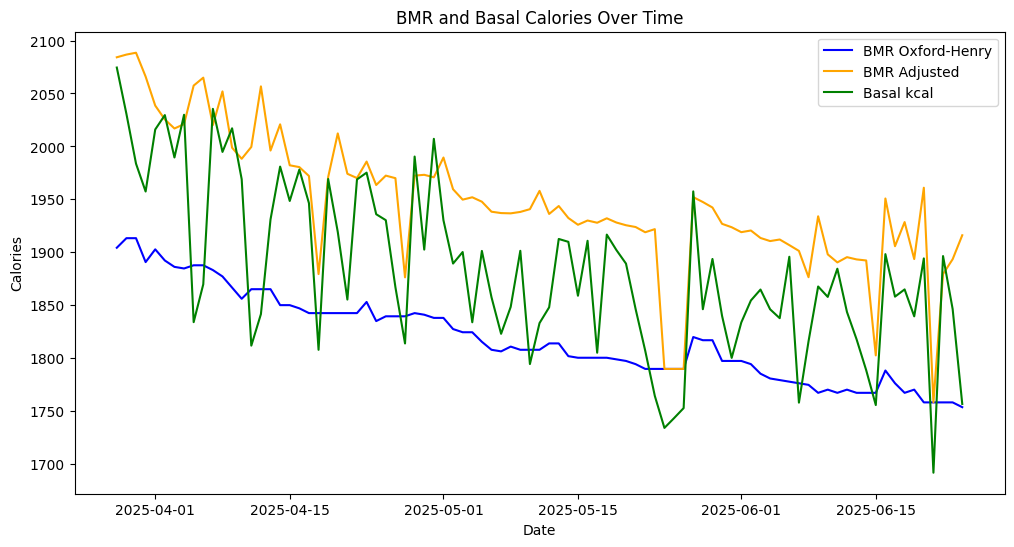

In [11]:

plt.figure(figsize=(12, 6))
plt.plot(daily.index, daily["bmr_oxford"], label="BMR Oxford-Henry", color="blue")
plt.plot(daily.index, daily["bmr_adj"], label="BMR Adjusted", color="orange")
plt.plot(daily.index, daily["basal_kcal"], label="Basal kcal", color="green")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Calories")
plt.title("BMR and Basal Calories Over Time")
plt.show()

In [12]:
import numpy as np
from sklearn.linear_model import LinearRegression

mask = daily[["bmr_adj","basal_kcal"]].dropna()
X = mask["bmr_adj"].values.reshape(-1,1)
y = mask["basal_kcal"].values

reg = LinearRegression().fit(X, y)
daily["bmr_calibrated"] = reg.predict(daily["bmr_adj"].values.reshape(-1,1))


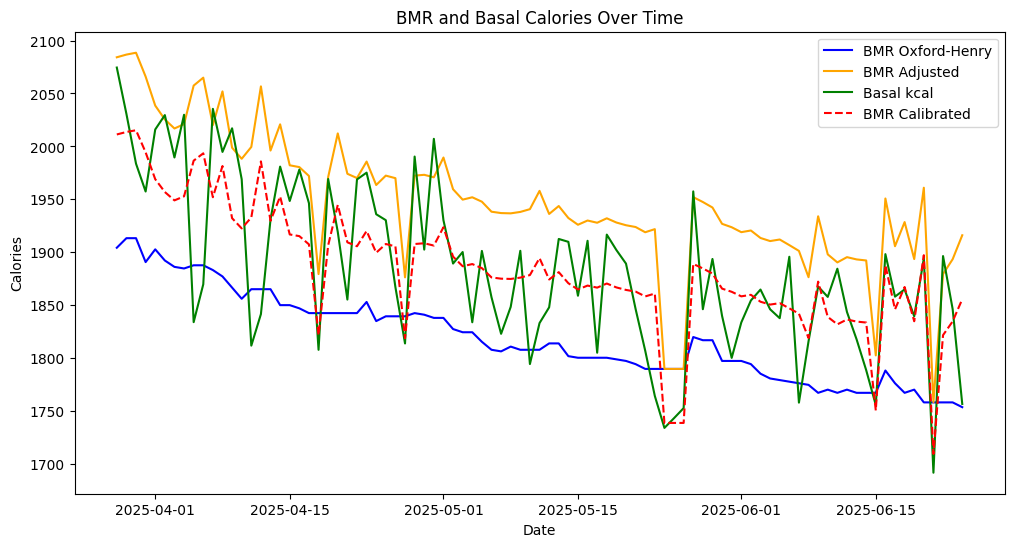

In [13]:

plt.figure(figsize=(12, 6))
plt.plot(daily.index, daily["bmr_oxford"], label="BMR Oxford-Henry", color="blue")
plt.plot(daily.index, daily["bmr_adj"], label="BMR Adjusted", color="orange")
plt.plot(daily.index, daily["basal_kcal"], label="Basal kcal", color="green")
plt.plot(daily.index, daily["bmr_calibrated"], label="BMR Calibrated", color="red", linestyle="--")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Calories")
plt.title("BMR and Basal Calories Over Time")
plt.show()

Now that we have several measures of bmr (standard formula, apple health, our own adjusted formula + a linear regression between both),  we can now estimate our maintenance calories by using our weight drop and our caloric intake

we can then compare to what apple says (bmr + active calories) -> we can find an accuracy for active calories

## Estimating Maintenance Calories from Weight Loss and Caloric Intake

Now we'll calculate our true maintenance calories using the fundamental principle that weight change reflects the energy balance between calories consumed and calories burned.

### Approach:
1. **Calculate weight change rate** - Track daily weight fluctuations to determine overall trend
2. **Apply energy balance equation** - Use the fact that 1 lb of body weight ≈ 3500 kcal
3. **Derive maintenance calories** - Adjust intake based on observed weight loss to find true maintenance
4. **Compare with Apple Health estimates** - Validate against BMR + Active Calories to assess accuracy

This will allow us to:
- Determine our actual Total Daily Energy Expenditure (TDEE)
- Evaluate the accuracy of Apple Health's active calorie measurements
- Calibrate our BMR models against real-world data

In [14]:
# Calculate weight change and maintenance calories
weight_data = daily[["weight_ffill", "diet_kcal"]].dropna()

# Calculate weight change rate (kg per day)
start_weight = weight_data["weight_ffill"].iloc[0]
end_weight = weight_data["weight_ffill"].iloc[-1]
days = len(weight_data)
weight_change_kg = end_weight - start_weight
weight_change_rate_kg_per_day = weight_change_kg / days

# Convert to calories (1 kg fat ≈ 7700 kcal)
kcal_per_kg = 7700
weight_change_kcal_per_day = weight_change_rate_kg_per_day * kcal_per_kg

# Calculate average daily intake
avg_daily_intake = weight_data["diet_kcal"].mean()

# Estimate maintenance calories
# If losing weight: maintenance = intake - weight_loss_kcal
# If gaining weight: maintenance = intake + weight_gain_kcal
maintenance_calories = avg_daily_intake - weight_change_kcal_per_day

print(f"Weight change: {weight_change_kg:.2f} kg over {days} days")
print(f"Weight change rate: {weight_change_rate_kg_per_day:.4f} kg/day")
print(f"Weight change (kcal/day): {weight_change_kcal_per_day:.1f} kcal/day")
print(f"Average daily intake: {avg_daily_intake:.0f} kcal")
print(f"Estimated maintenance calories: {maintenance_calories:.0f} kcal")

# Compare with Apple Health estimates
daily["apple_tdee"] = daily["basal_kcal"] + daily["active_kcal"]
avg_apple_tdee = daily["apple_tdee"].mean()
print(f"Apple Health TDEE estimate: {avg_apple_tdee:.0f} kcal")
print(f"Difference: {maintenance_calories - avg_apple_tdee:.0f} kcal")

Weight change: -10.00 kg over 88 days
Weight change rate: -0.1136 kg/day
Weight change (kcal/day): -875.0 kcal/day
Average daily intake: 2099 kcal
Estimated maintenance calories: 2974 kcal
Apple Health TDEE estimate: 2784 kcal
Difference: 190 kcal


## Analysis Ideas: Beyond Basic Maintenance Calorie Estimation

Now that we have our baseline maintenance calorie estimate, there are several interesting directions we can explore:

### 📊 **Visualization & Pattern Analysis**
- **Calorie balance over time** - Plot daily surplus/deficit vs weight change trends
- **Weekly patterns** - Analyze weekday vs weekend eating/activity patterns
- **Correlation heatmaps** - Visualize relationships between all health metrics
- **Activity vs calorie burn efficiency** - Steps/exercise minutes vs active calories

### 🔬 **Advanced Regression Analysis**
- **Multi-variable TDEE prediction** - Use activity, sleep, HR, etc. to predict daily energy expenditure
- **Weight prediction models** - Forecast weight based on calorie balance and metabolic factors
- **Apple Health accuracy assessment** - Compare predicted vs actual active calories
- **Seasonal/temporal trends** - Time-series analysis of metabolic changes

### 🤖 **Machine Learning Approaches**
- **Random Forest/XGBoost** - Non-linear models for TDEE prediction
- **Time series forecasting** - LSTM/ARIMA models for weight trajectory
- **Clustering analysis** - Identify distinct activity/metabolic patterns
- **Feature importance** - Which metrics best predict energy expenditure?

### 🎯 **Specific Questions to Investigate**
- How does sleep quality affect next-day metabolism?
- What's the relationship between HRV and calorie burn efficiency?
- Can we predict "cheat days" from activity patterns?
- How accurate are different BMR formulas for your specific case?

**Which of these directions interests you most?** We could start with correlation analysis and move toward predictive modeling.

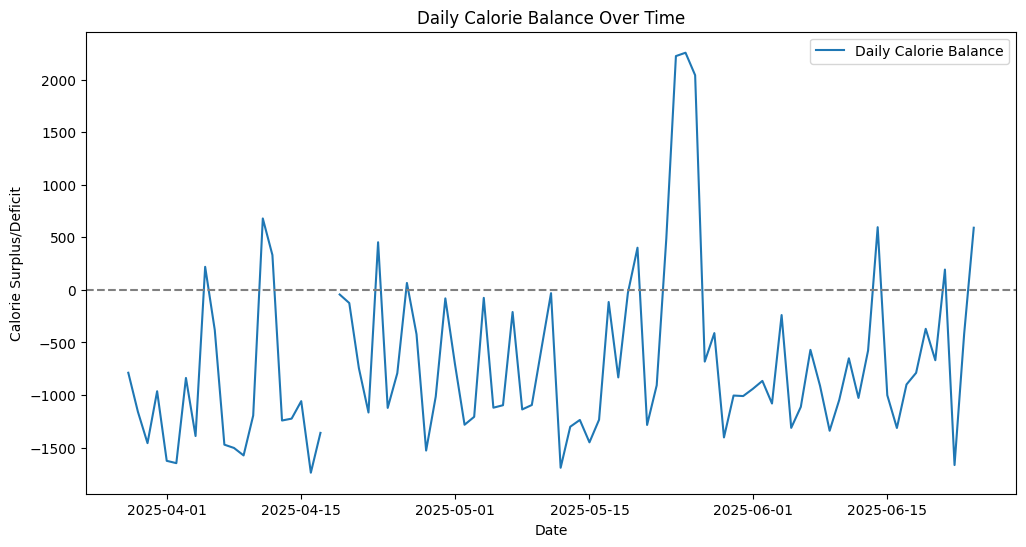

<Figure size 1000x500 with 0 Axes>

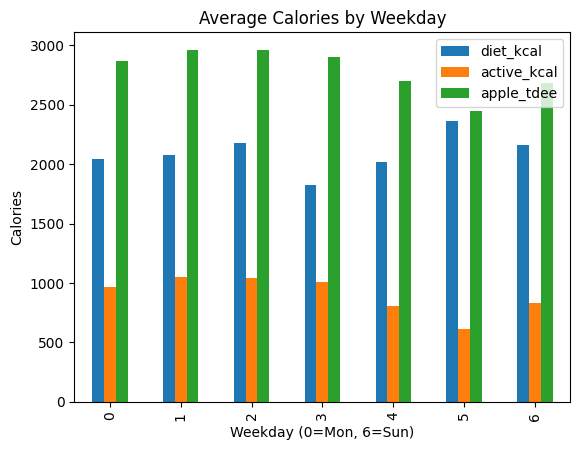

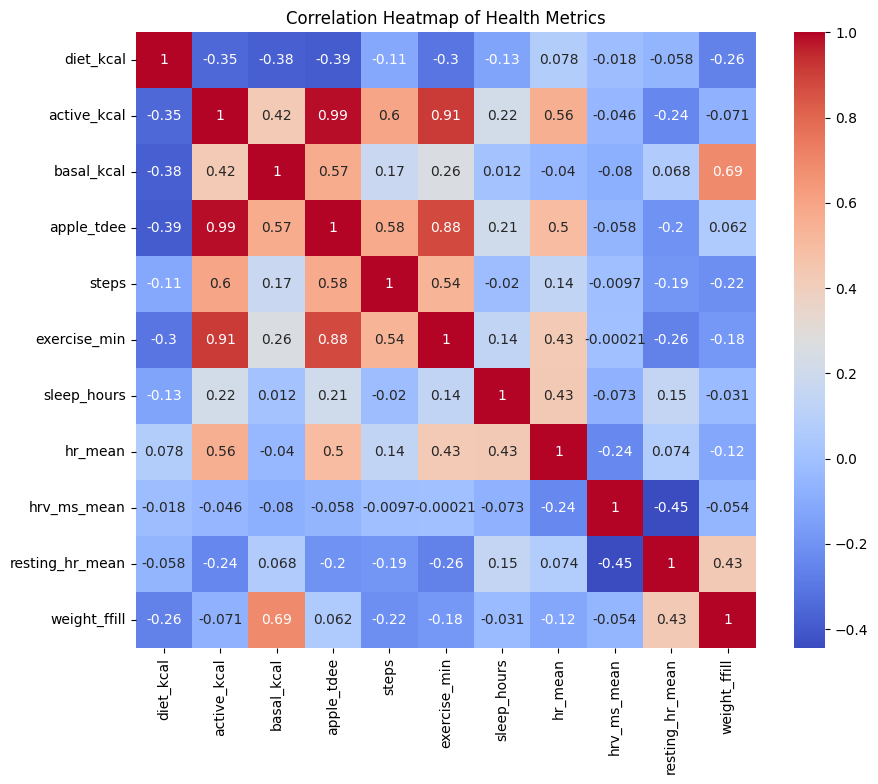

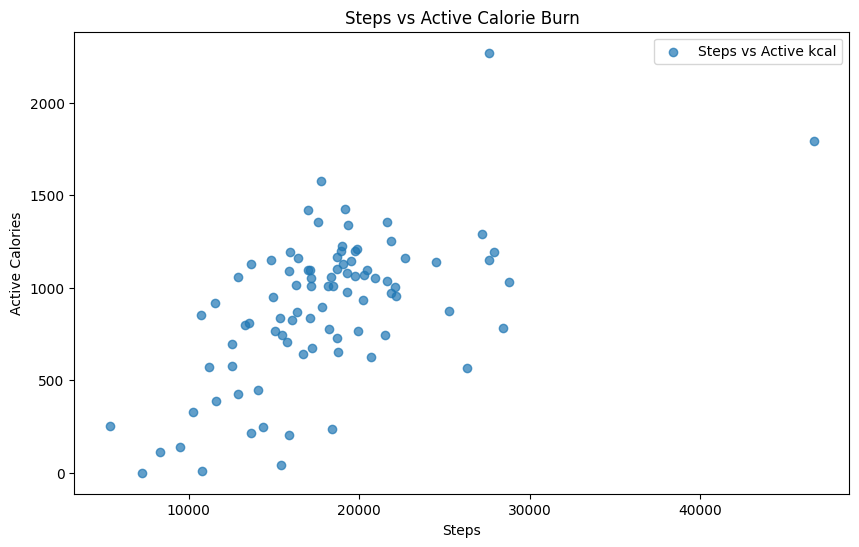

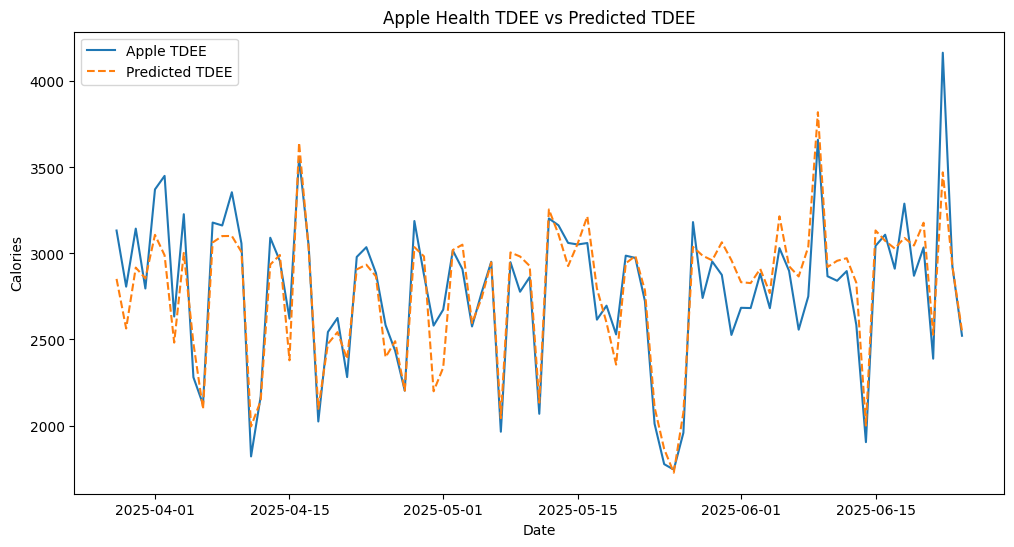

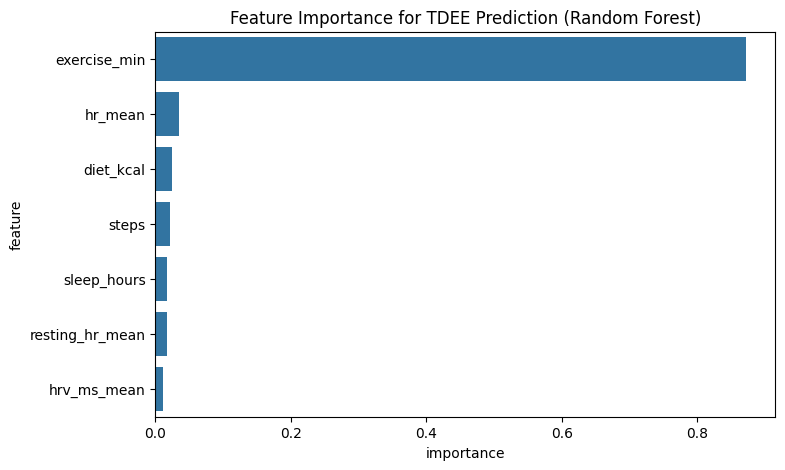

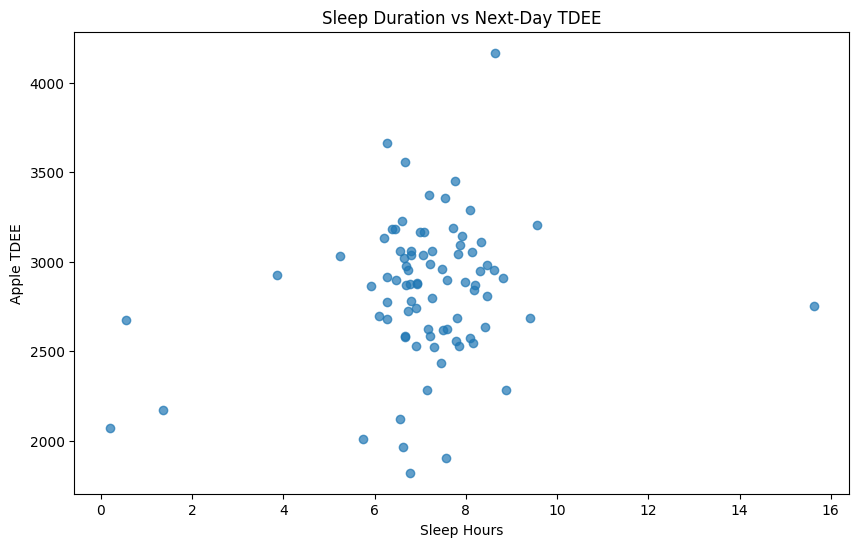

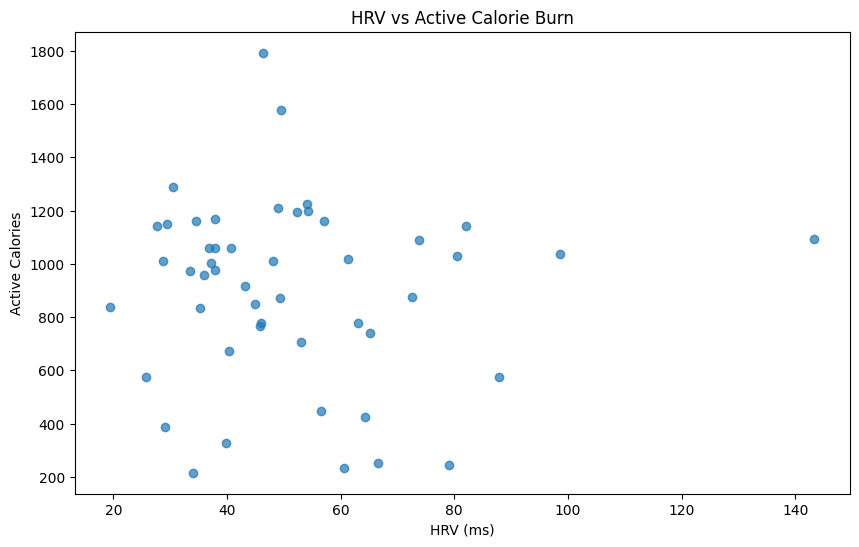

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Visualization & Pattern Analysis

# 1. Calorie balance over time
daily["calorie_balance"] = daily["diet_kcal"] - daily["apple_tdee"]
plt.figure(figsize=(12, 6))
plt.plot(daily.index, daily["calorie_balance"], label="Daily Calorie Balance")
plt.ylabel("Calorie Surplus/Deficit")
plt.xlabel("Date")
plt.title("Daily Calorie Balance Over Time")
plt.axhline(0, color="gray", linestyle="--")
plt.legend()
plt.show()

# 2. Weekly patterns: weekday vs weekend
daily["weekday"] = pd.to_datetime(daily.index).weekday
weekday_means = daily.groupby("weekday")[["diet_kcal", "active_kcal", "apple_tdee"]].mean()
plt.figure(figsize=(10, 5))
weekday_means.plot(kind="bar")
plt.title("Average Calories by Weekday")
plt.xlabel("Weekday (0=Mon, 6=Sun)")
plt.ylabel("Calories")
plt.show()

# 3. Correlation heatmap
corr = daily[["diet_kcal", "active_kcal", "basal_kcal", "apple_tdee", "steps", "exercise_min", "sleep_hours", "hr_mean", "hrv_ms_mean", "resting_hr_mean", "weight_ffill"]].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap of Health Metrics")
plt.show()

# 4. Activity vs calorie burn efficiency
plt.figure(figsize=(10, 6))
plt.scatter(daily["steps"], daily["active_kcal"], alpha=0.7, label="Steps vs Active kcal")
plt.xlabel("Steps")
plt.ylabel("Active Calories")
plt.title("Steps vs Active Calorie Burn")
plt.legend()
plt.show()

# Advanced Regression Analysis

# Multi-variable TDEE prediction (Linear Regression)
features = ["diet_kcal", "steps", "exercise_min", "sleep_hours", "hr_mean", "hrv_ms_mean", "resting_hr_mean"]
X_multi = daily[features].fillna(0)
y_tdee = daily["apple_tdee"].fillna(0)
reg_multi = LinearRegression().fit(X_multi, y_tdee)
daily["tdee_predicted"] = reg_multi.predict(X_multi)


# Apple Health accuracy assessment
plt.figure(figsize=(12, 6))
plt.plot(daily.index, daily["apple_tdee"], label="Apple TDEE")
plt.plot(daily.index, daily["tdee_predicted"], label="Predicted TDEE", linestyle="--")
plt.legend()
plt.title("Apple Health TDEE vs Predicted TDEE")
plt.xlabel("Date")
plt.ylabel("Calories")
plt.show()

# Machine Learning Approaches (Random Forest for TDEE prediction)
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_multi, y_tdee)
daily["tdee_rf_predicted"] = rf.predict(X_multi)

# Feature importance
importances = rf.feature_importances_
feature_importance_df = pd.DataFrame({"feature": features, "importance": importances}).sort_values("importance", ascending=False)
plt.figure(figsize=(8, 5))
sns.barplot(x="importance", y="feature", data=feature_importance_df)
plt.title("Feature Importance for TDEE Prediction (Random Forest)")
plt.show()

# Specific Questions

# Sleep quality effect on next-day metabolism
plt.figure(figsize=(10, 6))
plt.scatter(daily["sleep_hours"], daily["apple_tdee"], alpha=0.7)
plt.xlabel("Sleep Hours")
plt.ylabel("Apple TDEE")
plt.title("Sleep Duration vs Next-Day TDEE")
plt.show()

# HRV vs calorie burn efficiency
plt.figure(figsize=(10, 6))
plt.scatter(daily["hrv_ms_mean"], daily["active_kcal"], alpha=0.7)
plt.xlabel("HRV (ms)")
plt.ylabel("Active Calories")
plt.title("HRV vs Active Calorie Burn")
plt.show()


In [20]:
# Handle NaN values in calorie_balance before prediction
calorie_balance_filled = daily["calorie_balance"].fillna(0)


# Weight prediction model (simple linear regression on calorie balance)
weight_mask = daily[["weight_ffill", "calorie_balance"]].dropna()
X_weight = weight_mask["calorie_balance"].values.reshape(-1, 1)
y_weight = weight_mask["weight_ffill"].values
reg_weight = LinearRegression().fit(X_weight, y_weight)
daily["weight_predicted"] = reg_weight.predict(daily["calorie_balance"].values.reshape(-1, 1))


from sklearn.metrics import r2_score

# R² for multi-variable TDEE prediction (Linear Regression)
r2_tdee_linear = r2_score(y_tdee, daily["tdee_predicted"])
print("Linear Regression TDEE R²:", r2_tdee_linear)

# R² for Random Forest TDEE prediction
r2_tdee_rf = r2_score(y_tdee, daily["tdee_rf_predicted"])
print("Random Forest TDEE R²:", r2_tdee_rf)

# R² for weight prediction (if weight_predicted is present)
if "weight_predicted" in daily.columns:
    mask = ~daily["weight_predicted"].isna() & ~daily["weight_ffill"].isna()
    r2_weight = r2_score(daily.loc[mask, "weight_ffill"], daily.loc[mask, "weight_predicted"])
    print("Weight Prediction R²:", r2_weight)


ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values